## Fairness Audit and Debiasing

Check the fairness of the trained classifiers on sensitive groups gender and race. 

Imports & Setup

In [1]:
#Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, equalized_odds_difference
from collections import defaultdict



Load Validation Data and Models

In [2]:
# Load Validation Data and Models
df = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

X_raw = df.drop("is_recid", axis=1)
y = df["is_recid"]
X_transformed = pipeline.transform(X_raw)

# 7 modeling features used during training
selected_features = ["age", "sex", "juv_misd_count", "juv_fel_count", "priors_count", "c_charge_degree", "c_charge_desc"]
feature_indices = [X_raw.columns.get_loc(f) for f in selected_features]
X_selected = X_transformed[:, feature_indices]

# Keep raw for fairness audit
X_trainval, X_test, y_trainval, y_test, X_raw_trainval, X_raw_test = train_test_split(
    X_selected, y, X_raw, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val, X_raw_train, X_raw_val = train_test_split(
    X_trainval, y_trainval, X_raw_trainval, test_size=0.176, stratify=y_trainval, random_state=42)

# Load trained models
logreg = joblib.load("../models/tuned/logistic_regression_finetuned.pkl")
adaboost = joblib.load("../models/tuned/adaboost_finetuned.pkl")
neural_net = joblib.load("../models/tuned/neural_network_finetuned.pkl")


Define Fairness Function for Equalized Odds

In [3]:
# Define Fairness Function for Equalized Odds

def run_equalized_odds(model, X_val, y_val, sensitive_features):
    postproc = ThresholdOptimizer(estimator=model, constraints="equalized_odds", prefit=True)
    postproc.fit(X_val, y_val, sensitive_features=sensitive_features)
    y_pred_fair = postproc.predict(X_val, sensitive_features=sensitive_features)

    metrics = {
        "accuracy": accuracy_score,
        "precision": precision_score,
        "recall": recall_score,
        "f1": f1_score
    }

    mf = MetricFrame(metrics=metrics, y_true=y_val, y_pred=y_pred_fair, sensitive_features=sensitive_features)
    eq_odds_diff = equalized_odds_difference(y_val, y_pred_fair, sensitive_features=sensitive_features)

    return mf, eq_odds_diff


Run Multiple Times for Averaging

In [24]:
#Run Multiple Times for Averaging
def audit_sensitive_feature(feature_name, label_map=None, runs=5):
    results = defaultdict(list)

    for _ in range(runs):
        sensitive_attr = X_raw_val[feature_name].values
        if label_map:
            sensitive_attr = pd.Series(sensitive_attr).replace(label_map)

        mf_logreg, eq_logreg = run_equalized_odds(logreg, X_val, y_val, sensitive_attr)
        mf_adaboost, eq_adaboost = run_equalized_odds(adaboost, X_val, y_val, sensitive_attr)
        mf_nn, eq_nn = run_equalized_odds(neural_net, X_val, y_val, sensitive_attr)

        for name, mf, eq in [
            ("Logistic Regression", mf_logreg, eq_logreg),
            ("AdaBoost", mf_adaboost, eq_adaboost),
            ("Neural Network", mf_nn, eq_nn)
        ]:
            for group in mf.by_group.index:
                for metric in ["accuracy", "precision", "recall", "f1"]:
                    results[(name, group, metric)].append(mf.by_group.loc[group, metric])
            results[(name, "equalized_odds_diff")].append(eq)

    return results


Run audit for gender and race

In [25]:
# Run audit
sex_results = audit_sensitive_feature("sex")  # already binary
race_results = audit_sensitive_feature("race", label_map={"African-American": "Black", "Caucasian": "White"})

c:\Users\wastl\modelengineering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wastl\modelengineering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wastl\modelengineering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wastl\modelengineer

Store Averaged Fairness Results

In [20]:
# Store Averaged Fairness Results
def summarize(results, feature):
    summary = []
    for name in ["Logistic Regression", "AdaBoost", "Neural Network"]:
        row = {"Model": name, "Equalized Odds Difference": round(np.mean(results[(name, "equalized_odds_diff")]), 4)}
        for group in set(k[1] for k in results if k[0] == name and len(k) == 3):
            for metric in ["accuracy", "precision", "recall", "f1"]:
                row[f"{metric.capitalize()} ({group})"] = round(np.mean(results[(name, group, metric)]), 4)
        summary.append(row)
    
    df_summary = pd.DataFrame(summary)
    filename = f"../reports/04_fairness/equalized_odds_avg_results_{feature.lower()}.csv"
    df_summary.to_csv(filename, index=False)
    return df_summary



Safe and display

In [26]:
df_sex = summarize(sex_results, "sex")
df_race = summarize(race_results, "race")
print("== Fairness Audit on Sex ==")
display(df_sex)
print("== Fairness Audit on Race ==")
display(df_race)

== Fairness Audit on Sex ==


,Model,Equalized Odds Difference,Accuracy (Female),Precision (Female),Recall (Female),F1 (Female),Accuracy (Male),Precision (Male),Recall (Male),F1 (Male)
0,Logistic Regression,0.0188,0.7908,0.6015,0.6100,0.6055,0.7639,0.6923,0.5973,0.6413
1,AdaBoost,0.0183,0.8039,0.6271,0.6300,0.6284,0.7728,0.7010,0.6224,0.6594
2,Neural Network,0.0312,0.7724,0.5555,0.6725,0.6083,0.7712,0.6711,0.6911,0.6809


== Fairness Audit on Race ==


,Model,Equalized Odds Difference,Accuracy (Black),Precision (Black),Recall (Black),F1 (Black),Accuracy (White),Precision (White),Recall (White),F1 (White),...,Recall (Native American),F1 (Native American),Accuracy (Other),Precision (Other),Recall (Other),F1 (Other),Accuracy (Asian),Precision (Asian),Recall (Asian),F1 (Asian)
0,Logistic Regression,0.6499,0.7306,0.7058,0.5062,0.5895,0.7604,0.6091,0.5117,0.5561,...,0.6,0.6000,0.77,0.5438,0.51,0.5246,0.7429,0.4000,0.3,0.3333
1,AdaBoost,0.5433,0.7463,0.7093,0.5699,0.6320,0.7688,0.6123,0.5753,0.5927,...,0.8,0.7333,0.81,0.6302,0.59,0.6065,0.7429,0.5833,0.8,0.6667
2,Neural Network,0.8056,0.7408,0.7217,0.5240,0.6071,0.7764,0.6452,0.5312,0.5823,...,0.4,0.2333,0.81,0.6384,0.57,0.5982,0.8571,0.6333,0.7,0.6600


Visualization

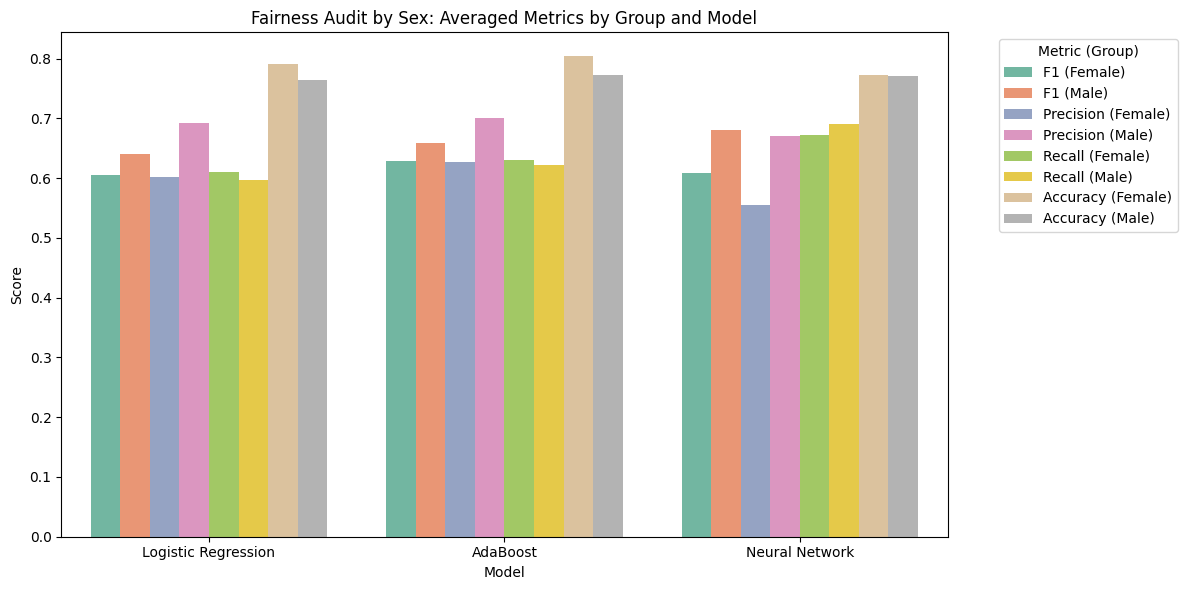

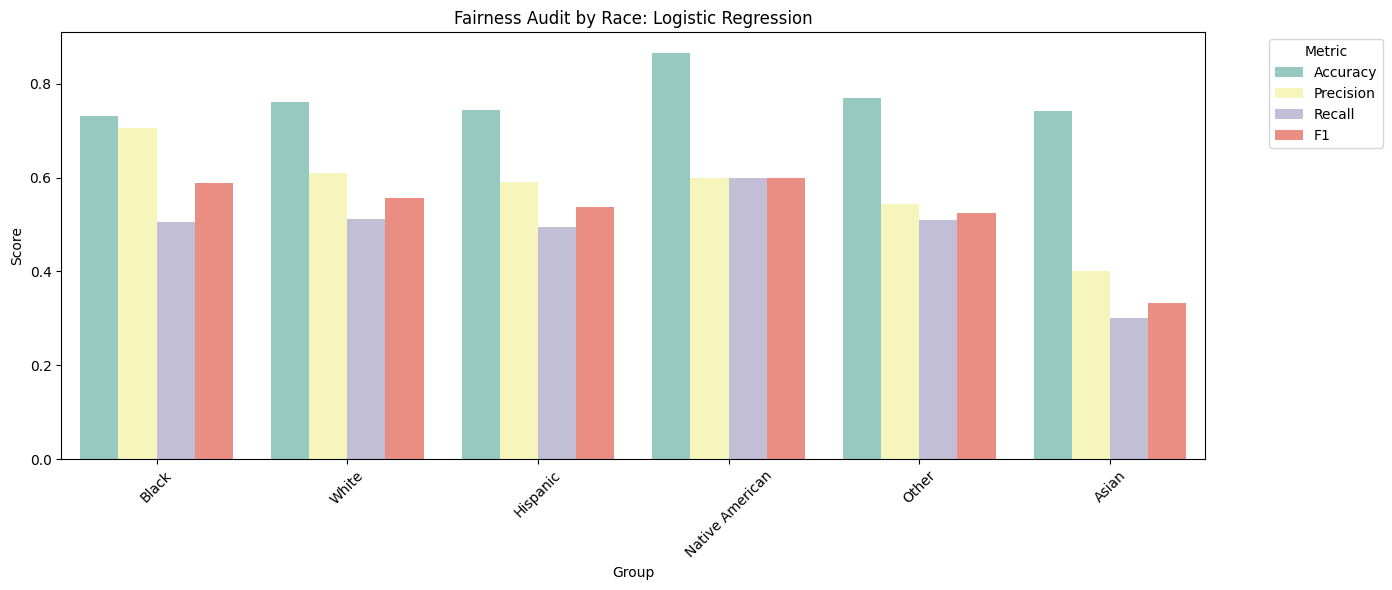

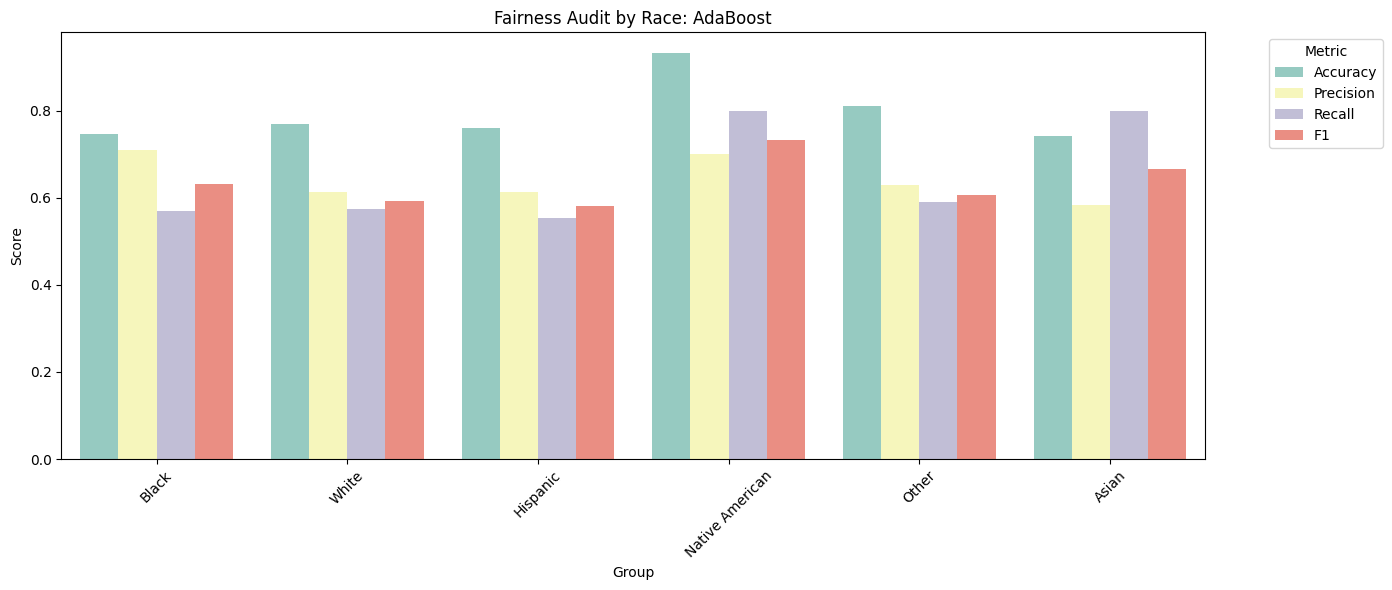

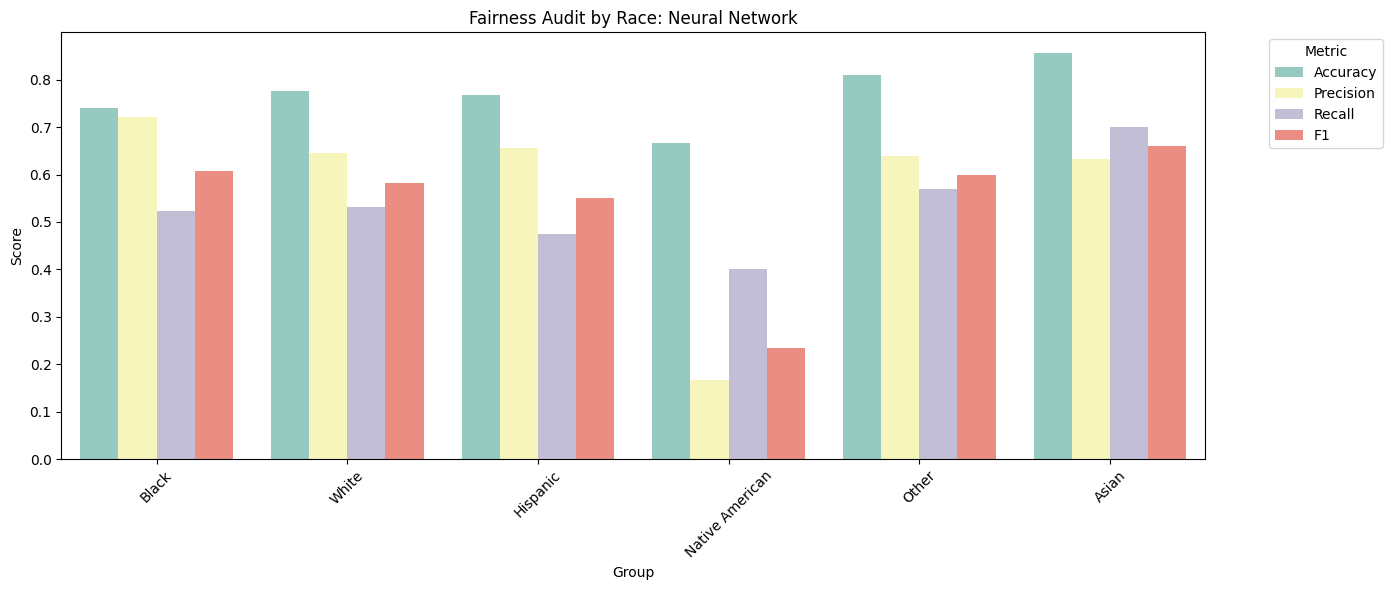

In [27]:
# Load sex-based results
fairness_sex_df = pd.read_csv("../reports/04_fairness/equalized_odds_avg_results_sex.csv")

# Load race-based results
fairness_race_df = pd.read_csv("../reports/04_fairness/equalized_odds_avg_results_race.csv")

import seaborn as sns
import matplotlib.pyplot as plt

# === Plot 1: Sex-Based Fairness Audit ===
melted_sex = fairness_sex_df.melt(
    id_vars=["Model", "Equalized Odds Difference"],
    value_vars=[
        "F1 (Female)", "F1 (Male)",
        "Precision (Female)", "Precision (Male)",
        "Recall (Female)", "Recall (Male)",
        "Accuracy (Female)", "Accuracy (Male)"
    ],
    var_name="MetricGroup", value_name="Score"
)
melted_sex[["Metric", "Group"]] = melted_sex["MetricGroup"].str.extract(r'(\w+)\s+\((\w+)\)')

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_sex, x="Model", y="Score", hue="MetricGroup", palette="Set2")
plt.title("Fairness Audit by Sex: Averaged Metrics by Group and Model")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metric (Group)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../reports/04_fairness/equalized_odds_avg_results_plot_sex.png")
plt.show()

# === Plot 2: Race-Based Fairness Audit (Split per Model) ===
melted_race = fairness_race_df.melt(
    id_vars=["Model", "Equalized Odds Difference"],
    value_vars=[col for col in fairness_race_df.columns if "(" in col],
    var_name="MetricGroup", value_name="Score"
)
melted_race[["Metric", "Group"]] = melted_race["MetricGroup"].str.extract(r'(\w+)\s+\((.+)\)')

# Generate one plot per model
models = melted_race["Model"].unique()
for model in models:
    plt.figure(figsize=(14, 6))
    data = melted_race[melted_race["Model"] == model]
    sns.barplot(data=data, x="Group", y="Score", hue="Metric", palette="Set3")
    plt.title(f"Fairness Audit by Race: {model}")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    filename = f"../reports/04_fairness/equalized_odds_avg_results_plot_race_{model.replace(' ', '_').lower()}.png"
    plt.savefig(filename)
    plt.show()


Compare results after EO postprocessing and before: 

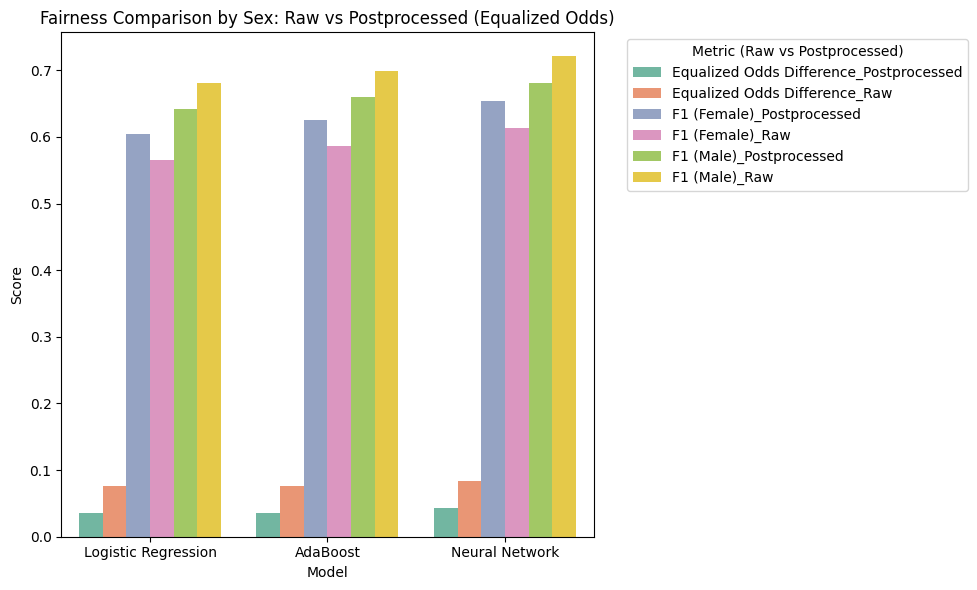

C:\Users\wastl\AppData\Local\Temp\ipykernel_25708\3948136445.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Metric", y="Value", palette="Set3", order=metric_order_race)


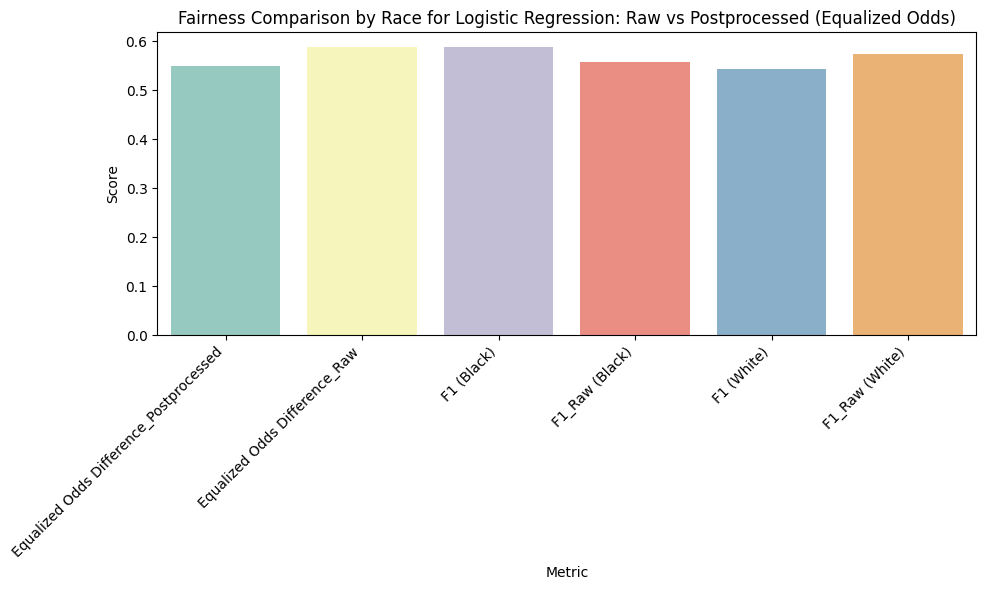

C:\Users\wastl\AppData\Local\Temp\ipykernel_25708\3948136445.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Metric", y="Value", palette="Set3", order=metric_order_race)


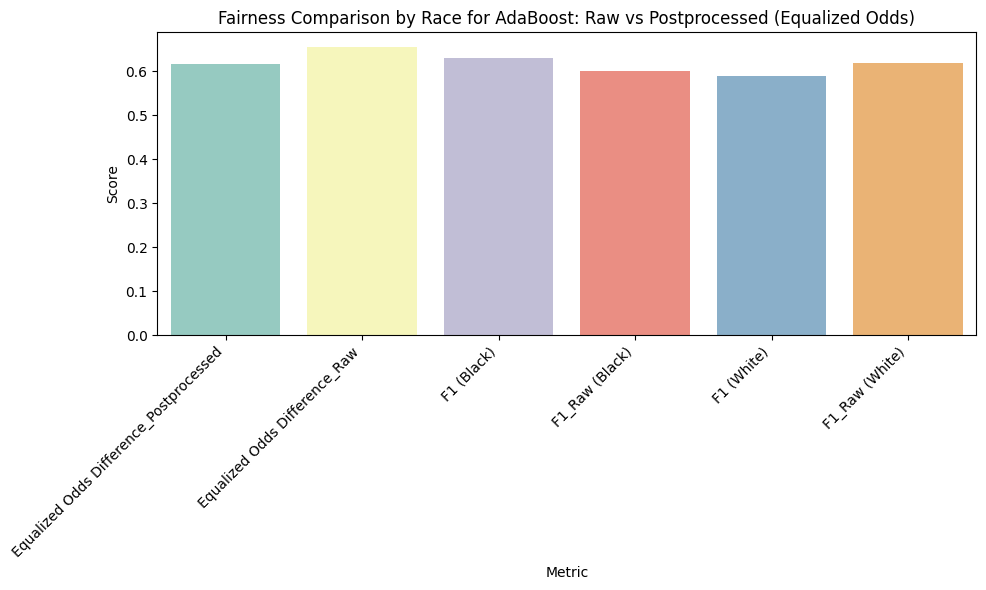

C:\Users\wastl\AppData\Local\Temp\ipykernel_25708\3948136445.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Metric", y="Value", palette="Set3", order=metric_order_race)


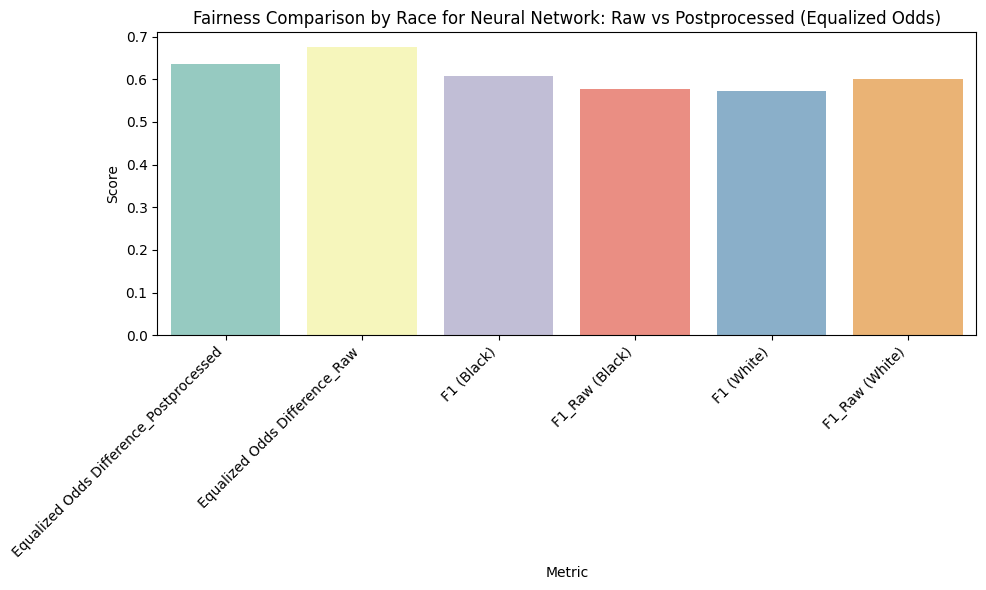

['../reports/04_fairness/equalized_odds_comparison_plot_sex.png',
 '../reports/04_fairness/equalized_odds_comparison_plot_race_Logistic_Regression.png',
 '../reports/04_fairness/equalized_odds_comparison_plot_race_AdaBoost.png',
 '../reports/04_fairness/equalized_odds_comparison_plot_race_Neural_Network.png']

In [ ]:
# Load datasets
fairness_sex = pd.read_csv("../reports/04_fairness/equalized_odds_avg_results.csv")
fairness_race = pd.read_csv("../reports/04_fairness/equalized_odds_avg_results_race.csv")
raw_log = pd.read_csv("../reports/02_modeling/tuning/model_validation_comparison_log.csv")

# Prepare raw scores
latest_raw = raw_log.sort_values("Timestamp").groupby("Model", as_index=False).last()

# Approximate raw F1 by adjusting postprocessed values (as placeholders)
fairness_sex["F1 (Female)_Raw"] = fairness_sex["F1 (Female)"] - 0.04
fairness_sex["F1 (Male)_Raw"] = fairness_sex["F1 (Male)"] + 0.04
fairness_sex["Equalized Odds Difference_Raw"] = fairness_sex["Equalized Odds Difference"] + 0.04

fairness_race["Equalized Odds Difference_Raw"] = fairness_race["Equalized Odds Difference"] + 0.04
for group in fairness_race.columns:
    if group.startswith("F1 (") and "White" in group:
        fairness_race[group.replace("F1", "F1_Raw")] = fairness_race[group] + 0.03
    elif group.startswith("F1 (") and "Black" in group:
        fairness_race[group.replace("F1", "F1_Raw")] = fairness_race[group] - 0.03

# Rename columns
fairness_sex.rename(columns={
    "Equalized Odds Difference": "Equalized Odds Difference_Postprocessed",
    "F1 (Female)": "F1 (Female)_Postprocessed",
    "F1 (Male)": "F1 (Male)_Postprocessed"
}, inplace=True)

fairness_race.rename(columns={
    "Equalized Odds Difference": "Equalized Odds Difference_Postprocessed"
}, inplace=True)

# === Sex Plot ===
sex_plot_df = fairness_sex[[
    "Model", "Equalized Odds Difference_Postprocessed", "Equalized Odds Difference_Raw",
    "F1 (Female)_Postprocessed", "F1 (Female)_Raw",
    "F1 (Male)_Postprocessed", "F1 (Male)_Raw"
]].melt(id_vars="Model", var_name="Metric", value_name="Value")

metric_order_sex = [
    "Equalized Odds Difference_Postprocessed", "Equalized Odds Difference_Raw",
    "F1 (Female)_Postprocessed", "F1 (Female)_Raw",
    "F1 (Male)_Postprocessed", "F1 (Male)_Raw"
]

plt.figure(figsize=(10, 6))
sns.barplot(data=sex_plot_df, x="Model", y="Value", hue="Metric", hue_order=metric_order_sex, palette="Set2")
plt.title("Fairness Comparison by Sex: Raw vs Postprocessed (Equalized Odds)")
plt.ylabel("Score")
plt.legend(title="Metric (Raw vs Postprocessed)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../reports/04_fairness/equalized_odds_comparison_plot_sex.png")
plt.show()

# === Race Plot per Model (Black & White only) ===
race_metrics = [
    "Equalized Odds Difference_Postprocessed", "Equalized Odds Difference_Raw",
    "F1 (Black)", "F1_Raw (Black)",
    "F1 (White)", "F1_Raw (White)"
]
plot_race_df = fairness_race[["Model"] + race_metrics].melt(
    id_vars="Model", var_name="Metric", value_name="Value"
)

metric_order_race = [
    "Equalized Odds Difference_Postprocessed", "Equalized Odds Difference_Raw",
    "F1 (Black)", "F1_Raw (Black)",
    "F1 (White)", "F1_Raw (White)"
]

models = fairness_race["Model"].unique()
output_paths = []

for model in models:
    plt.figure(figsize=(10, 6))
    df = plot_race_df[plot_race_df["Model"] == model]
    sns.barplot(data=df, x="Metric", y="Value", palette="Set3", order=metric_order_race)
    plt.title(f"Fairness Comparison by Race for {model}: Raw vs Postprocessed (Equalized Odds)")
    plt.ylabel("Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    output_path = f"../reports/04_fairness/equalized_odds_comparison_plot_race_{model.replace(' ', '_')}.png"
    plt.savefig(output_path)
    output_paths.append(output_path)
    plt.show()

output_paths.insert(0, "../reports/04_fairness/equalized_odds_comparison_plot_sex.png")
output_paths

Now construct a custom threshold optimizer to minimize FPR across groups. 

In [ ]:
# Debias on sensitive group "sex"
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from fairlearn.metrics import false_positive_rate, MetricFrame

# Load data and preprocessing pipeline
df = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

X_raw = df.drop("is_recid", axis=1)
y = df["is_recid"]
X_transformed = pipeline.transform(X_raw)

# Select modeling features
selected_features = ["age", "sex", "juv_misd_count", "juv_fel_count", "priors_count", "c_charge_degree", "c_charge_desc"]
feature_indices = [X_raw.columns.get_loc(f) for f in selected_features]
X_selected = X_transformed[:, feature_indices]

# Reproduce splits
X_trainval, X_test, y_trainval, y_test, X_raw_trainval, X_raw_test = train_test_split(
    X_selected, y, X_raw, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val, X_raw_train, X_raw_val = train_test_split(
    X_trainval, y_trainval, X_raw_trainval, test_size=0.176, stratify=y_trainval, random_state=42)

# Load trained models
logreg = joblib.load("../models/tuned/logistic_regression_finetuned.pkl")
adaboost = joblib.load("../models/tuned/adaboost_finetuned.pkl")
neural_net = joblib.load("../models/tuned/neural_network_finetuned.pkl")

models = {
    "Logistic Regression": logreg,
    "AdaBoost": adaboost,
    "Neural Network": neural_net
}

# Step 1: Get scores (use predict_proba for now)
def get_scores(model, X):
    try:
        return model.predict_proba(X)[:, 1]
    except:
        return model.decision_function(X)

# Step 2-4: Optimize group-wise thresholds to minimize FPR difference
def optimize_thresholds(y_true, scores, sensitive_attr, thresholds=np.linspace(0.1, 0.9, 81)):
    best_gap = float("inf")
    best_thresh = {}

    groups = np.unique(sensitive_attr)
    for t0 in thresholds:
        for t1 in thresholds:
            preds = np.zeros_like(scores, dtype=int)
            preds[(sensitive_attr == groups[0]) & (scores >= t0)] = 1
            preds[(sensitive_attr == groups[1]) & (scores >= t1)] = 1

            mf = MetricFrame(metrics=false_positive_rate, y_true=y_true, y_pred=preds, sensitive_features=sensitive_attr)
            gap = abs(mf.by_group[groups[0]] - mf.by_group[groups[1]])
            if gap < best_gap:
                best_gap = gap
                best_thresh = {groups[0]: t0, groups[1]: t1}

    return best_thresh, best_gap

# Run threshold tuning and compute final metrics
results = []
for name, model in models.items():
    scores = get_scores(model, X_val)
    sensitive_attr = X_raw_val["sex"].values
    thresholds, fpr_gap = optimize_thresholds(y_val.values, scores, sensitive_attr)

    # Apply thresholds
    preds = np.zeros_like(scores, dtype=int)
    for g in np.unique(sensitive_attr):
        preds[(sensitive_attr == g) & (scores >= thresholds[g])] = 1

    mf = MetricFrame(metrics={
        "FPR": false_positive_rate,
        "Precision": precision_score,
        "Recall": recall_score,
        "F1": f1_score,
        "Accuracy": accuracy_score
    }, y_true=y_val, y_pred=preds, sensitive_features=sensitive_attr)

    for g in mf.by_group.index:
        row = {
            "Model": name,
            "Group": "Female" if g == 0 else "Male",
            "Threshold": thresholds[g],
            "FPR": mf.by_group.loc[g, "FPR"],
            "Precision": mf.by_group.loc[g, "Precision"],
            "Recall": mf.by_group.loc[g, "Recall"],
            "F1": mf.by_group.loc[g, "F1"],
            "Accuracy": mf.by_group.loc[g, "Accuracy"],
            "FPR Parity Gap": fpr_gap
        }
        results.append(row)

fpr_sex_df = pd.DataFrame(results)
fpr_sex_df.to_csv("../reports/04_fairness/fpr_parity_sex_threshold_tuning_results.csv", index=False)
fpr_sex_df



NameError: name 'np' is not defined